# Enhancing Singapore Airlines' Service Through Automated Sentiment Analysis of Customer Reviews



**Motivation**



## Singapore Airlines Customer Reviews Dataset Information

The [Singapore Airlines Customer Reviews Dataset](https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews) aggregates 10,000 anonymized customer reviews, providing a broad perspective on the passenger experience with Singapore Airlines. 

The dimensions are shown below:
- **`published_date`**: Date and time of review publication.
- **`published_platform`**: Platform where the review was posted.
- **`rating`**: Customer satisfaction rating, from 1 (lowest) to 5 (highest).
- **`type`**: Specifies the content as a review.
- **`text`**: Detailed customer feedback.
- **`title`**: Summary of the review.
- **`helpful_votes`**: Number of users finding the review helpful.

## Importing Libraries

Please uncomment the code box below to pip install relevant dependencies for this notebook.

In [3]:
# !pip3 install -r requirements.txt

In [4]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm

# Plotting and Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Language Detection packages
# `langdetect` for detecting language
from langdetect import detect as langdetect_detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
# `langid` for an alternative language detection method
from langid import classify as langid_classify

import nltk
# Text Preprocessing and NLP
# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords

# Tokenizing sentences/words
from nltk.corpus import wordnet

# Tokenizing sentences/words
from nltk.tokenize import word_tokenize
# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer


# Regular expressions for text pattern matching
import re

# Word Cloud generation
from wordcloud import WordCloud

# For generating n-grams
from nltk.util import ngrams
from collections import Counter

## Data Preparation (Loading CSV)

Load the `final_df.csv` file into a pandas DataFrame `data`.

We have performed extensive preprocessing on our data.
1. Combined `singapore_airlines_reviews.csv` with `singapore_airlines_reviews_skytrax.csv` and `singapore_airlines_reviews_tripadvisor.csv`.
2. Dropped duplicates, removed outliers
3. Feature engineering (create `full_review` column)
4. Language detection
5. Porter Stemmer

In [5]:
data = pd.read_csv("./final_df.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11518 entries, 0 to 11517
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   year                   11518 non-null  int64 
 1   month                  11518 non-null  int64 
 2   sentiment              11518 non-null  object
 3   processed_full_review  11518 non-null  object
dtypes: int64(2), object(2)
memory usage: 360.1+ KB


In [6]:
data.head()

,year,month,sentiment,processed_full_review
0,2024,3,Neutral,ok use airlin go singapor london heathrow issu...
1,2024,3,Negative,don give money book paid receiv email confirm ...
2,2024,3,Positive,best airlin world best airlin world seat food ...
3,2024,3,Negative,premium economi seat singapor airlin not worth...
4,2024,3,Negative,imposs get promis refund book flight full mont...


# Exploratory Data Analysis (EDA)

In [7]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Summary Statistics

In [8]:
# View describe statistics of numerical variables
data.describe()

,year,month
count,11518.000000,11518.000000
mean,2019.785727,6.989234
std,1.817380,3.563813
min,2018.000000,1.000000
25%,2019.000000,4.000000
50%,2019.000000,8.000000
75%,2021.000000,10.000000
max,2024.000000,12.000000


/tmp/ipykernel_786/2281615537.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values, palette='viridis')


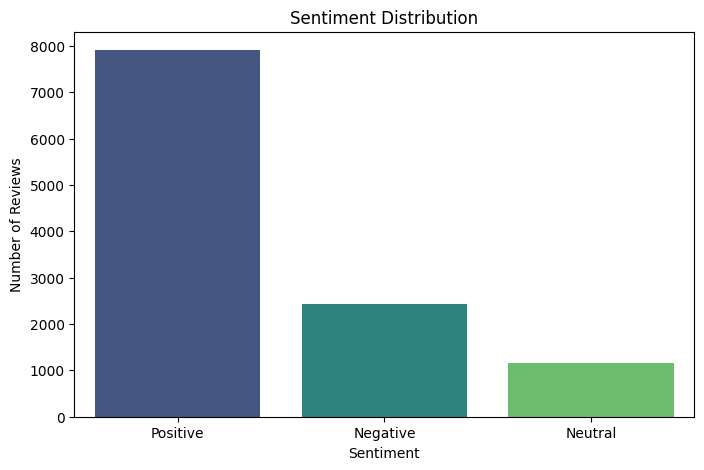

In [9]:
# Get the distribution of sentiment
sentiment_distribution = data['sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

## Distribution of Review Length

Here, we create a column `review_length` that returns the length of the `full_review` for each row.

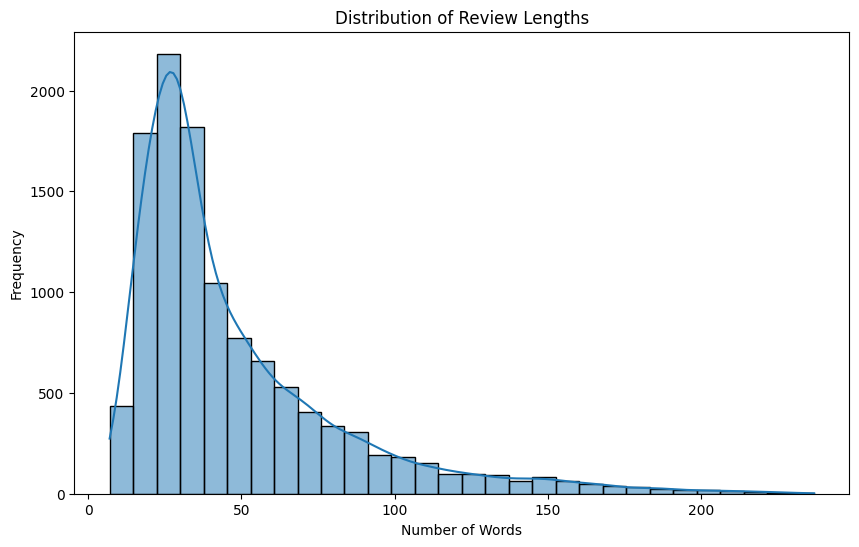

Review Length Statistics:
 count    11518.000000
mean        47.812988
std         35.200554
min          7.000000
25%         25.000000
50%         35.000000
75%         59.000000
max        237.000000
Name: review_length, dtype: float64


In [10]:
# Calculate review length in words
data['review_length'] = data['processed_full_review'].apply(lambda x: len(x.split()))

# Plot distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['review_length'], bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Print basic statistics for review length
print("Review Length Statistics:\n", data['review_length'].describe())

In [11]:
data.head()

,year,month,sentiment,processed_full_review,review_length
0,2024,3,Neutral,ok use airlin go singapor london heathrow issu...,132
1,2024,3,Negative,don give money book paid receiv email confirm ...,46
2,2024,3,Positive,best airlin world best airlin world seat food ...,17
3,2024,3,Negative,premium economi seat singapor airlin not worth...,71
4,2024,3,Negative,imposs get promis refund book flight full mont...,75


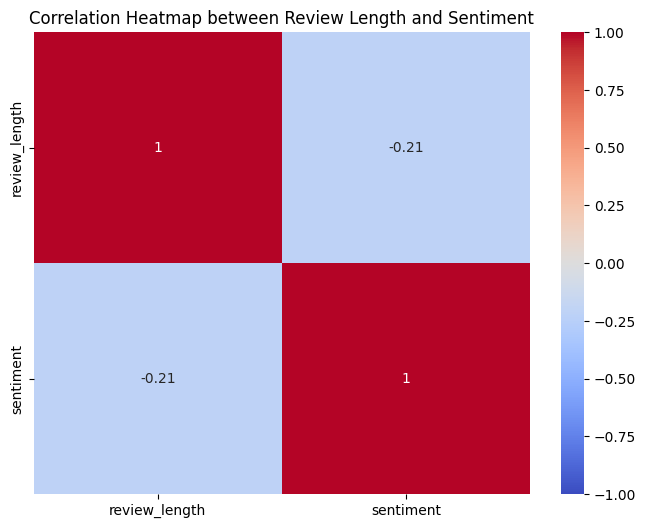

In [12]:
# Calculate the correlation matrix
correlation_matrix = data[['review_length', 'sentiment']].copy()

# Convert sentiment to numerical values for correlation calculation
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
correlation_matrix['sentiment'] = correlation_matrix['sentiment'].map(sentiment_mapping)

# Calculate the correlation
corr = correlation_matrix.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Review Length and Sentiment')
plt.show()

Based on the heatmap, we can see that `review_length` is **negatively correlated** to `sentiment`, which means that as the length of review increases, the sentiment of the review tends to decrease.

A possible explanation could be that a customer who leaves a review with a negative sentiment may write a longer, more detailed review, explaining their dissatisfaction or the problems they encountered. On the other hand, a customer who leaves a positive review may write a short, positive review like "Great service!" or "Excellent!".

## Temporal Analysis

In [13]:
print(data.dtypes)

year                      int64
month                     int64
sentiment                object
processed_full_review    object
review_length             int64
dtype: object


### Number of Reviews per Year


Yearly Review Analysis:
--------------------------------------------------

Year: 2018
Total Reviews: 2596
Average Reviews per Month: 216.3
Sentiment Distribution:
  Positive: 83.8%
  Negative: 7.5%
  Neutral:  8.7%

Year: 2019
Total Reviews: 5129
Average Reviews per Month: 427.4
Sentiment Distribution:
  Positive: 80.5%
  Negative: 9.1%
  Neutral:  10.4%

Year: 2020
Total Reviews: 888
Average Reviews per Month: 74.0
Sentiment Distribution:
  Positive: 76.2%
  Negative: 15.2%
  Neutral:  8.6%

Year: 2021
Total Reviews: 96
Average Reviews per Month: 8.0
Sentiment Distribution:
  Positive: 34.4%
  Negative: 62.5%
  Neutral:  3.1%

Year: 2022
Total Reviews: 1184
Average Reviews per Month: 98.7
Sentiment Distribution:
  Positive: 24.8%
  Negative: 63.9%
  Neutral:  11.3%

Year: 2023
Total Reviews: 1111
Average Reviews per Month: 92.6
Sentiment Distribution:
  Positive: 37.5%
  Negative: 50.0%
  Neutral:  12.4%

Year: 2024
Total Reviews: 514
Average Reviews per Month: 42.8
Sentiment Distri

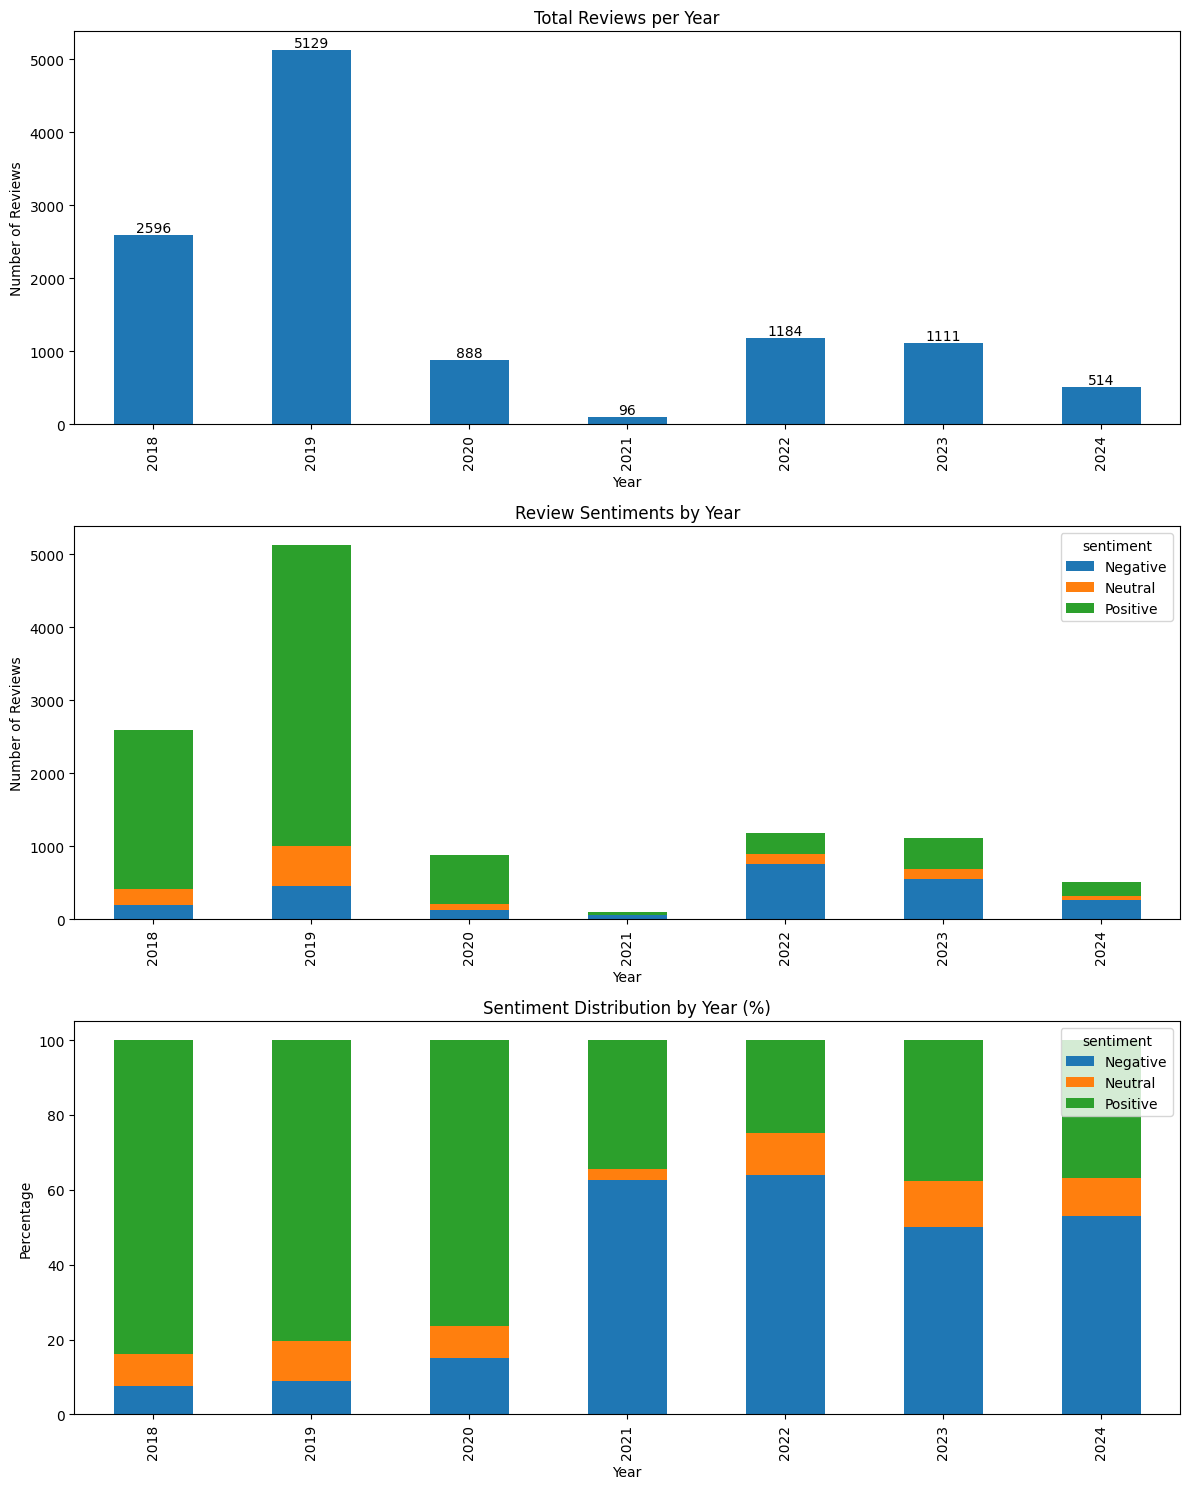

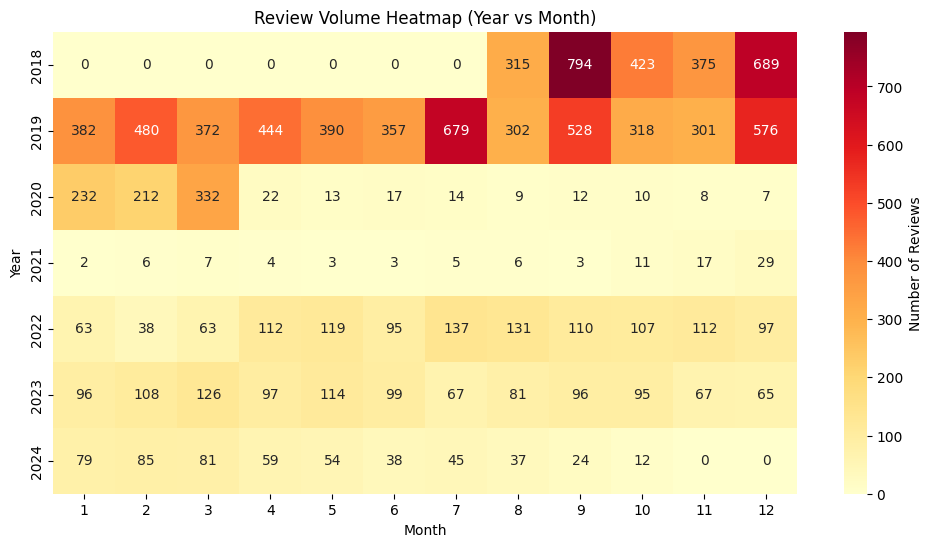

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_reviews_per_year(data):
    """
    Analyze and visualize the number of reviews per year
    """
    # Basic count per year
    yearly_counts = data['year'].value_counts().sort_index()
    
    # Count by sentiment per year
    sentiment_counts = data.groupby(['year', 'sentiment']).size().unstack(fill_value=0)
    
    # Calculate percentages
    sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
    
    # Create visualizations
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot 1: Total reviews per year
    yearly_counts.plot(kind='bar', ax=ax1)
    ax1.set_title('Total Reviews per Year')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Reviews')
    for i, v in enumerate(yearly_counts):
        ax1.text(i, v, str(v), ha='center', va='bottom')
    
    # Plot 2: Stacked bar chart of sentiments
    sentiment_counts.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Review Sentiments by Year')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Number of Reviews')
    
    # Plot 3: Sentiment percentages
    sentiment_percentages.plot(kind='bar', stacked=True, ax=ax3)
    ax3.set_title('Sentiment Distribution by Year (%)')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Percentage')
    
    plt.tight_layout()
    
    # Create summary statistics
    summary = pd.DataFrame({
        'total_reviews': yearly_counts,
        'avg_reviews_per_month': sentiment_counts.sum(axis=1) / 12,
        'positive_ratio': sentiment_percentages['Positive'],
        'negative_ratio': sentiment_percentages['Negative'],
        'neutral_ratio': sentiment_percentages['Neutral']
    }).round(2)
    
    return {
        'yearly_counts': yearly_counts,
        'sentiment_counts': sentiment_counts,
        'sentiment_percentages': sentiment_percentages,
        'summary': summary
    }

def print_yearly_summary(results):
    """
    Print a formatted summary of the yearly analysis
    """
    print("\nYearly Review Analysis:")
    print("-" * 50)
    
    summary = results['summary']
    for year in summary.index:
        print(f"\nYear: {year}")
        print(f"Total Reviews: {summary.loc[year, 'total_reviews']}")
        print(f"Average Reviews per Month: {summary.loc[year, 'avg_reviews_per_month']:.1f}")
        print("Sentiment Distribution:")
        print(f"  Positive: {summary.loc[year, 'positive_ratio']:.1f}%")
        print(f"  Negative: {summary.loc[year, 'negative_ratio']:.1f}%")
        print(f"  Neutral:  {summary.loc[year, 'neutral_ratio']:.1f}%")

def analyze_monthly_patterns(data):
    """
    Analyze monthly patterns within years
    """
    # Create monthly counts
    monthly_counts = data.groupby(['year', 'month']).size().unstack(fill_value=0)
    
    # Create heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(monthly_counts, 
                annot=True, 
                fmt='d', 
                cmap='YlOrRd',
                cbar_kws={'label': 'Number of Reviews'})
    plt.title('Review Volume Heatmap (Year vs Month)')
    plt.xlabel('Month')
    plt.ylabel('Year')
    
    return monthly_counts

# Example usage:
results = analyze_reviews_per_year(data)
print_yearly_summary(results)
monthly_patterns = analyze_monthly_patterns(data)

In [15]:
data['year'].value_counts()

year
2019    5129
2018    2596
2022    1184
2023    1111
2020     888
2024     514
2021      96
Name: count, dtype: int64

In [16]:
data['sentiment'].value_counts()

sentiment
Positive    7913
Negative    2441
Neutral     1164
Name: count, dtype: int64

### Number of reviews by month

In [17]:
data.head()

,year,month,sentiment,processed_full_review,review_length
0,2024,3,Neutral,ok use airlin go singapor london heathrow issu...,132
1,2024,3,Negative,don give money book paid receiv email confirm ...,46
2,2024,3,Positive,best airlin world best airlin world seat food ...,17
3,2024,3,Negative,premium economi seat singapor airlin not worth...,71
4,2024,3,Negative,imposs get promis refund book flight full mont...,75


/tmp/ipykernel_786/3439443353.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=reviews_by_month.index, y=reviews_by_month.values, palette='viridis')


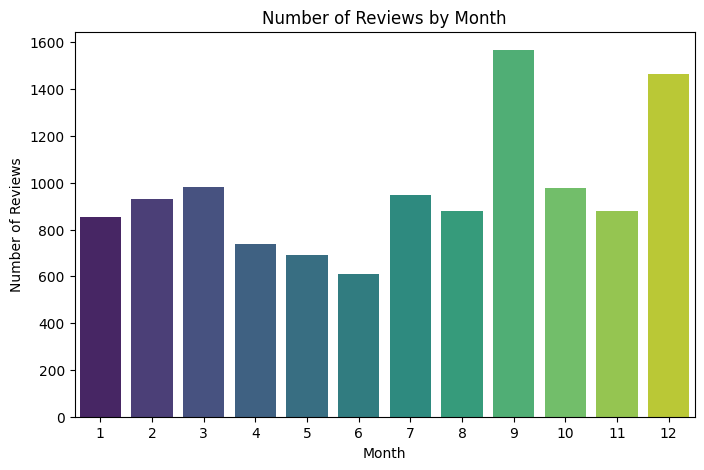

In [18]:
# Number of reviews by month
reviews_by_month = data['month'].value_counts().sort_index()

# Plot reviews by month
plt.figure(figsize=(8, 5))
sns.barplot(x=reviews_by_month.index, y=reviews_by_month.values, palette='viridis')
plt.title('Number of Reviews by Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

### Word cloud after text processing

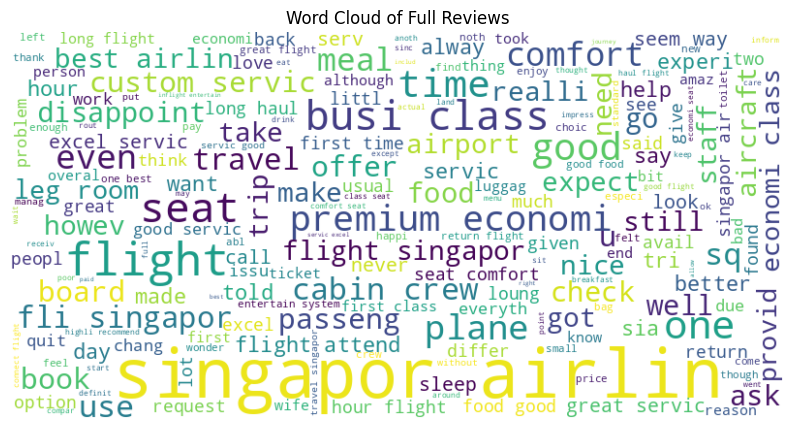

In [19]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['processed_full_review']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Full Reviews')
plt.show()

## Distribution of Sentiment

### Sentiment trends over time

sentiment   Negative    Neutral   Positive
year                                      
2018        7.511556   8.705701  83.782743
2019        9.066095  10.430883  80.503022
2020       15.202703   8.558559  76.238739
2021       62.500000   3.125000  34.375000
2022       63.935811  11.317568  24.746622
2023       50.045005  12.421242  37.533753
2024       53.112840  10.116732  36.770428


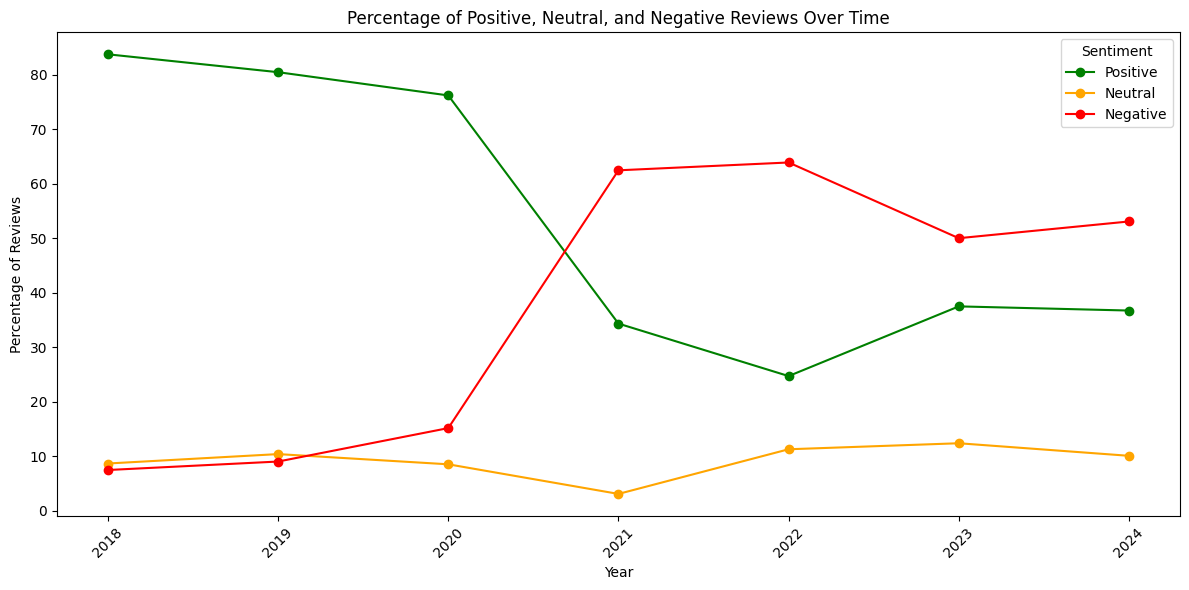

In [20]:
# Count the total number of reviews for each sentiment by year
sentiment_counts = data.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

# Calculate the percentage of each sentiment per month
sentiment_percentage = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100


print(sentiment_percentage)


# Convert PeriodIndex to string
sentiment_percentage.index = sentiment_percentage.index.astype(str)

# Plot all three sentiment lines on one axis
plt.figure(figsize=(12, 6))

# Plot Positive sentiment
plt.plot(sentiment_percentage.index, sentiment_percentage['Positive'], color='green', marker='o', label='Positive')

# Plot Neutral sentiment
plt.plot(sentiment_percentage.index, sentiment_percentage['Neutral'], color='orange', marker='o', label='Neutral')

# Plot Negative sentiment
plt.plot(sentiment_percentage.index, sentiment_percentage['Negative'], color='red', marker='o', label='Negative')

# Add labels and title
plt.title('Percentage of Positive, Neutral, and Negative Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage of Reviews')
plt.xticks(rotation=45)

# Add a legend to distinguish between the lines
plt.legend(title='Sentiment')

# Display the plot
plt.tight_layout()
plt.show()

## Top N-grams by sentiment

### Positive reviews

In [21]:
# Function to generate n-grams
def generate_ngrams(text, n=2):
    words = text.split()
    n_grams = ngrams(words, n)
    return [' '.join(grams) for grams in n_grams]

# Generate n-grams for each sentiment, default n = 2
def ngram_by_sentiment(data, sentiment_label, n=2):
    filtered_data = data[data['sentiment'] == sentiment_label]
    ngrams_list = [ngram for sublist in filtered_data['processed_full_review'].apply(lambda x: generate_ngrams(x, n)) for ngram in sublist]
    ngram_freq = Counter(ngrams_list).most_common(10)
    return pd.DataFrame(ngram_freq, columns=[f'{n}-gram', 'Frequency'])

            2-gram  Frequency
0  singapor airlin       4506
1       busi class       1251
2       cabin crew        980
3     fli singapor        836
4  premium economi        769
5      best airlin        702
6     great servic        600
7     excel servic        584
8         leg room        549
9  flight singapor        537


/tmp/ipykernel_786/2843920592.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='2-gram', data=positive_bigrams, palette='magma')


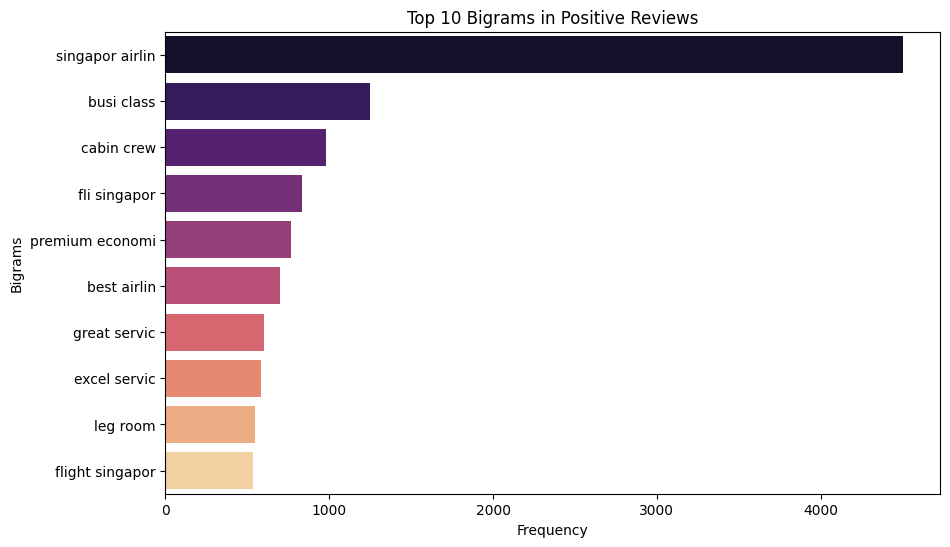

In [22]:
# Get top 10 bigrams for positive reviews
positive_bigrams = ngram_by_sentiment(data, 'Positive', n=2)
print(positive_bigrams)

# Plot bigrams in positive reviews
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='2-gram', data=positive_bigrams, palette='magma')
plt.title('Top 10 Bigrams in Positive Reviews')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')

plt.show()

                   3-gram  Frequency
0     fli singapor airlin        646
1        long haul flight        230
2  flight singapor airlin        202
3  travel singapor airlin        177
4        noth much troubl        162
5         busi class seat        152
6       best airlin world        140
7  singapor airlin flight        139
8         one best airlin        138
9   singapor airlin alway        137


/tmp/ipykernel_786/68462332.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='3-gram', data=positive_bigrams, palette='magma')


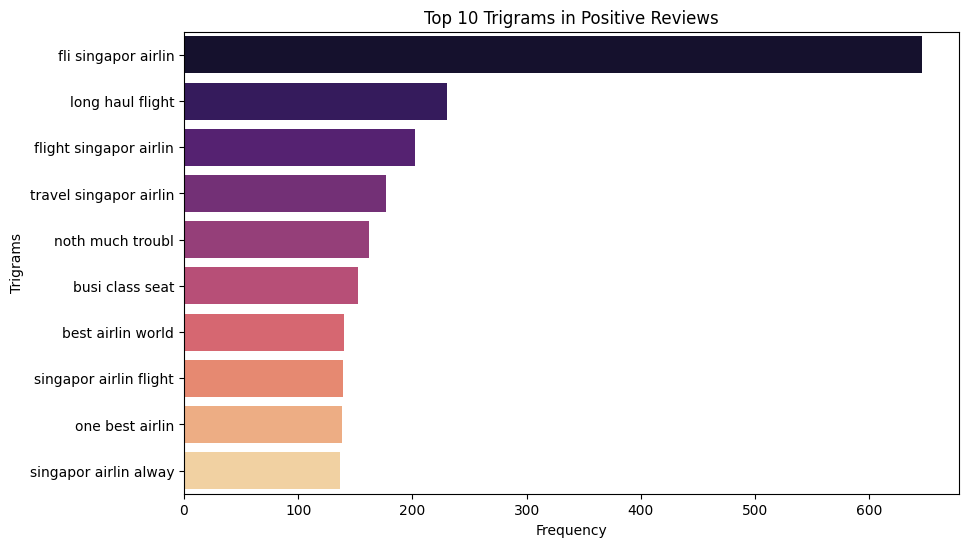

In [23]:
# Get top 10 trigrams for positive reviews
positive_bigrams = ngram_by_sentiment(data, 'Positive', n=3)
print(positive_bigrams)

# Plot bigrams in positive reviews
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='3-gram', data=positive_bigrams, palette='magma')
plt.title('Top 10 Trigrams in Positive Reviews')
plt.xlabel('Frequency')
plt.ylabel('Trigrams')

plt.show()

### Negative reviews

            2-gram  Frequency
0  singapor airlin       1958
1    custom servic        685
2  premium economi        440
3       busi class        440
4     fli singapor        206
5  flight singapor        195
6     singapor air        178
7      book flight        156
8      hour flight        150
9    cancel flight        142


/tmp/ipykernel_786/1476722894.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='2-gram', data=negative_bigrams, palette='magma')


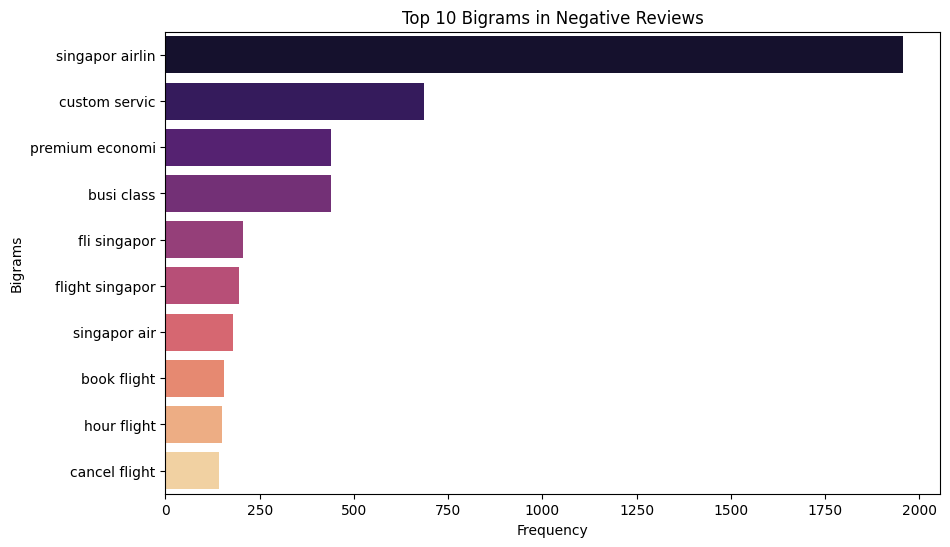

In [24]:
# Get top 10 bigrams for negative reviews
negative_bigrams = ngram_by_sentiment(data, 'Negative', n=2)
print(negative_bigrams)

# Plot bigrams in negative reviews
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='2-gram', data=negative_bigrams, palette='magma')
plt.title('Top 10 Bigrams in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

                   3-gram  Frequency
0     fli singapor airlin        138
1  flight singapor airlin         64
2     singapor airlin not         57
3  travel singapor airlin         54
4  experi singapor airlin         52
5         busi class seat         51
6      call custom servic         50
7      poor custom servic         49
8   terribl custom servic         48
9      never fli singapor         47


/tmp/ipykernel_786/1836038381.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='3-gram', data=negative_bigrams, palette='magma')


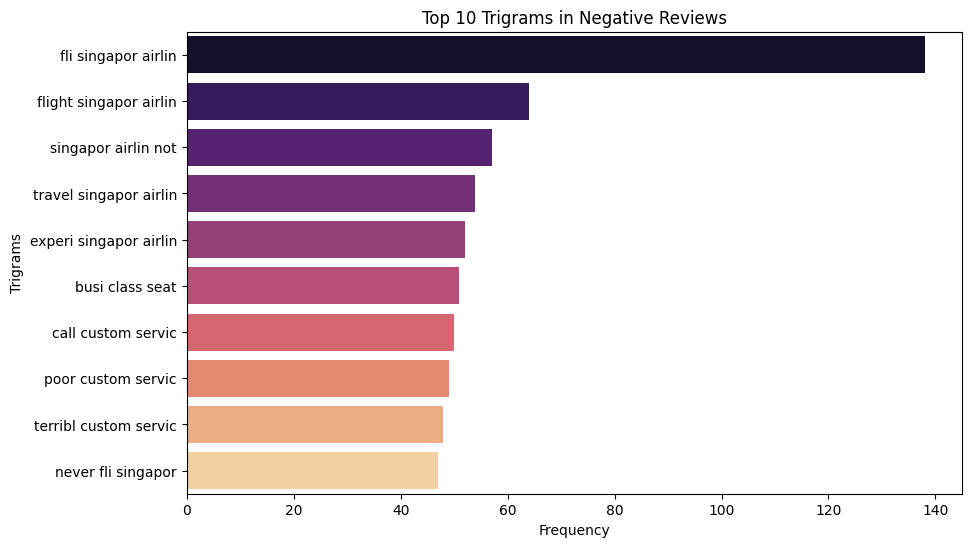

In [25]:
# Get top 10 trigrams for positive reviews
negative_bigrams = ngram_by_sentiment(data, 'Negative', n=3)
print(negative_bigrams)

# Plot bigrams in positive reviews
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='3-gram', data=negative_bigrams, palette='magma')
plt.title('Top 10 Trigrams in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.show()

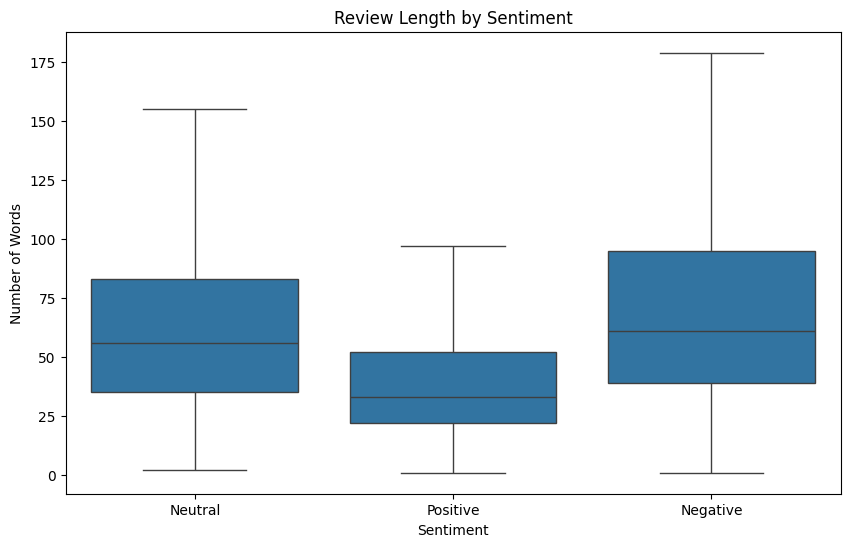

In [51]:
# Create a column for review length (assuming you have a 'full_review' or 'processed_full_review' column)
data['processed_review_length'] = data['processed_full_review'].apply(lambda x: len(x.split()))

# Plot the distribution of review length by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='processed_review_length', data=data, showfliers=False)
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.show()

### Word Cloud for Each Sentiment (Positive, Neutral, Negative)

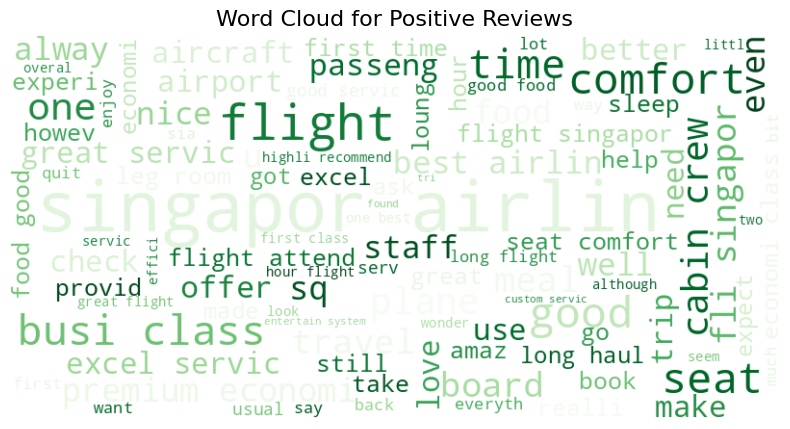

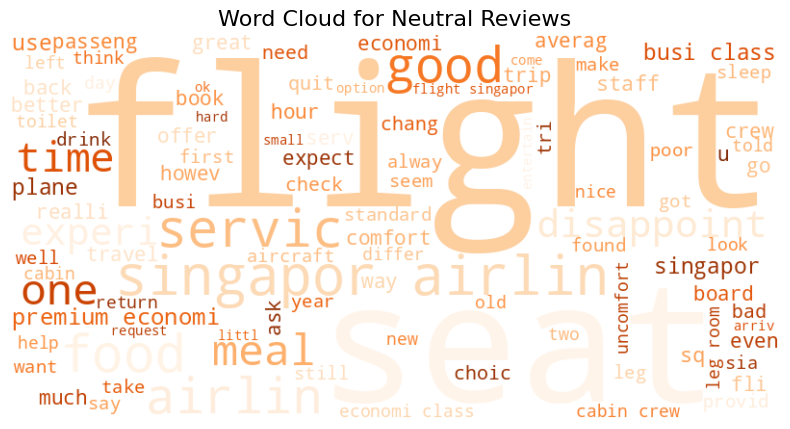

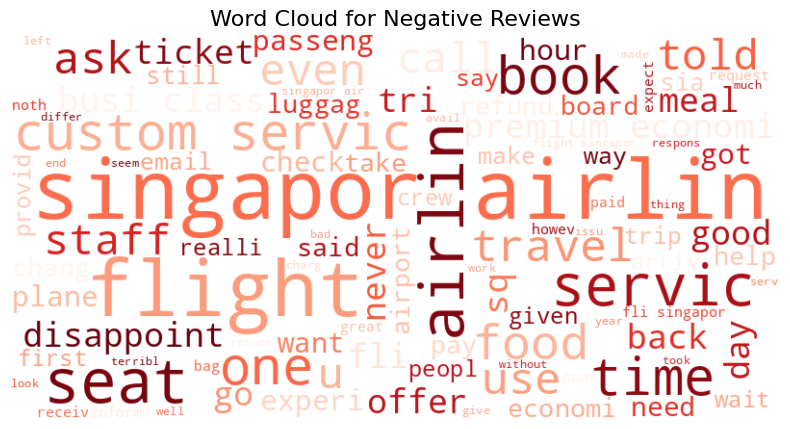

In [26]:
# Function to generate word clouds
def generate_wordcloud(text_data, sentiment_label, color):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color, max_words=100).generate(text_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment_label} Reviews', fontsize=16)
    plt.show()

# Filter the reviews by sentiment and join them into a single string for word cloud generation
positive_text = ' '.join(data[data['sentiment'] == 'Positive']['processed_full_review'])
neutral_text = ' '.join(data[data['sentiment'] == 'Neutral']['processed_full_review'])
negative_text = ' '.join(data[data['sentiment'] == 'Negative']['processed_full_review'])

# Generate word clouds for each sentiment
generate_wordcloud(positive_text, 'Positive', 'Greens')
generate_wordcloud(neutral_text, 'Neutral', 'Oranges')
generate_wordcloud(negative_text, 'Negative', 'Reds')
